## Imports

Import all the required library in once place.

In [6]:
# !pip install -U keras
# !python -m spacy download en_core_web_md
# !pip install spacy
# !pip install pandas
# !pip install h5py
# !pip install matplotlib

In [78]:
import os
import pickle
import pandas as pd
import numpy as np
import spacy
import keras

from collections import Counter

from keras.models import Model, load_model
from keras.layers import BatchNormalization, Dense, Input
from keras.callbacks import ModelCheckpoint, CSVLogger

from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

## Global helper functions

These helper functions will be used throughout for stuff like pickling/unpickling data at each checkpoints, etc.

In [2]:
def data_exists(namespace, name):
    dirname = os.path.join('data', namespace)
    filename = os.path.join(dirname, name + '.pickle')

    return os.path.exists(filename)


def save_data(namespace, name, content):
    dirname = os.path.join('data', namespace)
    if not os.path.exists(dirname):
        os.mkdir(dirname)

    filename = os.path.join(dirname, name + '.pickle')

    with open(filename, 'wb') as f:
        pickle.dump(content, f)


def load_data(namespace, name):
    dirname = os.path.join('data', namespace)
    filename = os.path.join(dirname, name + '.pickle')

    with open(filename, 'rb') as f:
        return pickle.load(f)

## Load the Quora dataset

In [3]:
TRAIN_FILE = 'train.csv'
data = pd.read_csv(TRAIN_FILE)

## Analyse the dataset

In [16]:
# Total number of entries
ad_total_entries = len(data)
print("Total entries: {}".format(ad_total_entries))

# Types of entries
ad_positive_entries = len(data[data['is_duplicate'] == 1])
print("Total positive entries: {}".format(ad_positive_entries))

ad_negative_entries = len(data[data['is_duplicate'] == 0])
print("Total negative entries: {}".format(ad_negative_entries))

ad_percent_pos = 100.0 * ad_positive_entries / ad_total_entries
print("Percent positive entries: {}".format(ad_percent_pos))

ad_percent_neg = 100.0 * ad_negative_entries / ad_total_entries
print("Percent negative entries: {}".format(ad_percent_neg))

Total entries: 404290
Total positive entries: 149263
Total negative entries: 255027
Percent positive entries: 36.9197853026
Percent negative entries: 63.0802146974


In [5]:
# Analyse sample questions
data.head(n=20)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


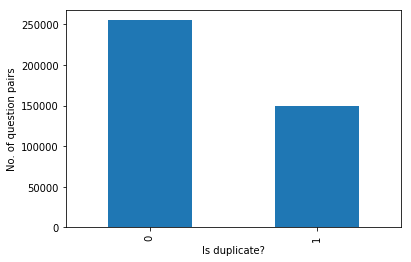

In [27]:
plt.figure();
plt.xlabel('Is duplicate?')
plt.ylabel('No. of question pairs')
data['is_duplicate'].value_counts().plot(kind='bar')

In [4]:
# Word count visualization
positive_examples = data[data['is_duplicate'] == 1]
negative_examples = data[data['is_duplicate'] == 0]

positive_str_lens = (positive_examples['question1'].str.len() - positive_examples['question2'].str.len()).abs()
negative_str_lens = (negative_examples['question1'].str.len() - negative_examples['question2'].str.len()).abs()

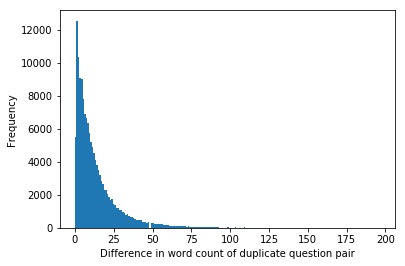

In [7]:
plt.figure()
plt.xlabel('Difference in word count of duplicate question pair')
plt.ylabel('No. of question pairs')
positive_str_lens.plot(kind='hist', bins=200)

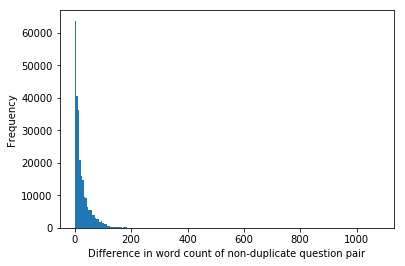

In [8]:
plt.figure()
plt.xlabel('Difference in word count of non-duplicate question pair')
plt.ylabel('No. of question pairs')
negative_str_lens.plot(kind='hist', bins=200)

In [12]:
print(positive_str_lens.mean())
print(positive_str_lens.std())

13.1507138407
14.3912979075


In [13]:
print(negative_str_lens.mean())
print(negative_str_lens.std())

24.2979315753
29.5356970183


In [14]:
# Jaccard index
def jaccard_index(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    
    return 1.0 * intersection / union

In [24]:
# Jaccard similarity of a row
def jaccard_index_row(row):
    return jaccard_index(str(row['question1']), str(row['question2']))

In [25]:
positive_jaccards = positive_examples.apply(jaccard_index_row, axis=1)
negative_jaccards = negative_examples.apply(jaccard_index_row, axis=1)

print("DONE")

DONE


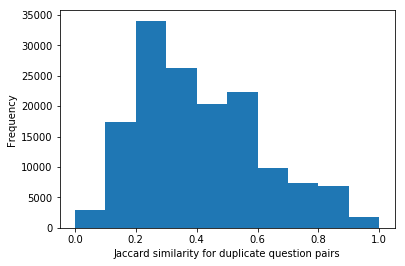

In [28]:
plt.figure()
plt.xlabel('Jaccard similarity for duplicate question pairs')
positive_jaccards.plot(kind='hist')

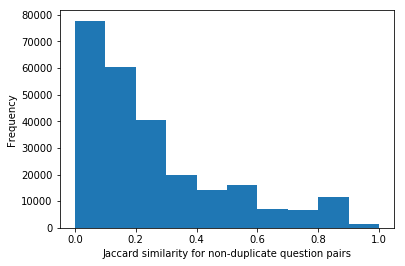

In [29]:
plt.figure()
plt.xlabel('Jaccard similarity for non-duplicate question pairs')
negative_jaccards.plot(kind='hist')

## Benchmark

In [62]:
def get_test_set(data):
    split = 0.9
    test_index = int(0.9 * len(data))
    
    return (pd.DataFrame({'question1':data['question1'][test_index:,], 'question2':data['question2'][test_index:,]}),
            data['is_duplicate'][test_index:,])

In [63]:
bm_data = get_test_set(data)

In [65]:
bm_data[0].head()

,question1,question2
363861,How do you become both a lawyer and a doctor?,How can you become a lawyer?
363862,How do I get rid of the smell from a cat spray...,How can I stop my cat from spraying?
363863,How does one start a small business?,How can I start a successful small business?
363864,Which are the best GMAT coaching institutes in...,What is the best coaching institute for GMAT i...
363865,What are some good jobs for civil engineer?,Which are the best jobs in civil engineering?


In [66]:
def jaccard_threshold(value):
    if value > 0.5:
        return 1
    else:
        return 0

In [74]:
def run_test_set_bm(bm_data):
    data = bm_data[0]
    actual = bm_data[1]
    predictions = data.apply(jaccard_index_row, axis=1).apply(jaccard_threshold)
    
    rights = (predictions == actual).sum()
    wrongs = (predictions != actual).sum()

    accuracy = 1.0 * rights / (rights + wrongs)
    
    return accuracy
    
run_test_set_bm(bm_data)

0.6515372628558708

The baseline model gives an accuracy of 65.1%.

## Feature extraction

We can extract features in several different ways, and we goota try them all too.

In [35]:
nlp = spacy.load('en_default')

In [6]:
# Get GloVe vectors for each word
def get_vectors_for_text(nlp, text):
    return np.array([w.vector for w in nlp(text)])

# Take the mean of all the rows, thus getting a single
# row in the end
def mean_pool(text_vectors):
    return np.mean(text_vectors, axis=0)

# Take the max from all rows, thus getting a single
# row in the end
def max_pool(text_vectors):
    return np.max(text_vectors, axis=0)

# Concat of max and mean pool of all vectors
def features_for_text(nlp, text):
    vectors = get_vectors_for_text(nlp, text)
    
    return np.concatenate((max_pool(vectors), mean_pool(vectors)))

In [7]:
get_vectors_for_text(nlp, unicode(data.loc[0]['question1']))

array([[-0.038548  ,  0.54251999, -0.21843   , ...,  0.11798   ,
         0.24590001,  0.22872999],
       [-0.084961  ,  0.50199997,  0.0023823 , ..., -0.21511   ,
        -0.26304001, -0.0060173 ],
       [ 0.27204001, -0.06203   , -0.1884    , ...,  0.13015001,
        -0.18317001,  0.1323    ],
       ..., 
       [ 0.089187  ,  0.25792   ,  0.26282001, ...,  0.14421   ,
        -0.169     ,  0.26501   ],
       [-0.89548999,  0.38773   ,  0.64984   , ...,  0.1375    ,
        -0.26706001,  0.57568997],
       [-0.086864  ,  0.19160999,  0.10915   , ..., -0.01516   ,
         0.11108   ,  0.20649999]], dtype=float32)

In [33]:
def save_vectors(nlp, data):
    if data_exists('features', 'vectors'):
        return load_data('features', 'vectors')
    
    features = {
        'question1': [],
        'question2': [],
        'is_duplicate': []
    }
    
    for i in tqdm(range(len(data))):
        try:
            row = data.loc[i]
            q1 = features_for_text(nlp, unicode(row['question1']))
            q2 = features_for_text(nlp, unicode(row['question2']))

            features['question1'].append(q1)
            features['question2'].append(q2)
            features['is_duplicate'].append(row['is_duplicate'])
        except:
            pass
        
    features['question1'] = np.asarray(features['question1'])
    features['question2'] = np.asarray(features['question2'])
    features['is_duplicate'] = np.asarray(features['is_duplicate'])
    
    save_data('features', 'vectors', features)
    
    return features

In [9]:
print(nlp(u'hello').vector)

[ 0.25233001  0.10176    -0.67484999  0.21117     0.43492001  0.16542
  0.48260999 -0.81221998  0.041321    0.78501999 -0.077857   -0.66324002
  0.1464     -0.29289001 -0.25488001  0.019293   -0.20265     0.98232001
  0.028312   -0.081276   -0.1214      0.13125999 -0.17648     0.13556001
 -0.16361    -0.22574     0.055006   -0.20308     0.20717999  0.095785
  0.22481     0.21537    -0.32982001 -0.12241    -0.40031001 -0.079381
 -0.19958    -0.015083   -0.079139   -0.18132     0.20681    -0.36195999
 -0.30744001 -0.24422    -0.23113     0.09798     0.1463     -0.062738
  0.42934    -0.078038   -0.19627     0.65092999 -0.22807001 -0.30307999
 -0.12483    -0.17568    -0.14651     0.15361001 -0.29517999  0.15098999
 -0.51726002 -0.033564   -0.23108999 -0.78329998  0.018029   -0.15719
  0.02293     0.49639001  0.029225    0.05669     0.14616001 -0.19194999
  0.16244     0.23898     0.36431     0.45263001  0.2456      0.23803
  0.31399     0.34869999 -0.035791    0.56107998 -0.25345001  0.05

Save all vectors to a file to be used later

In [36]:
vectors = save_vectors(nlp, data)

## Build the network

I'm gonna be trying multiple networks with different hyper-parameters. I'm keen on knowing what kind of improvement each component can contribute.

In [11]:
# Define all combinations
model_params = {
    # Should we use batch normalization or not?
    'batch_norm': [True, False],
    
    # No. of weights in each layer. All layers will have the same
    # weights with ReLU activation
    'no_weights': [100, 200, 300],
    
    # No. of layers
    'no_layers': [2, 4, 6, 8]
}

# Generate all combinations
def generate_combinations(params):
    keys = params.keys()
    
    # Generate combinations of current key
    current_key = keys[0]
    current_combinations = []
    for value in params[current_key]:
        d = {}
        d[current_key] = value
        current_combinations.append(d)
        
    # Check if we need recursive processing
    if len(keys) > 1:
        other_combinations = generate_combinations({k:v for k,v in params.iteritems() if k != current_key})
        all_combinations = []
        
        for i in current_combinations:
            for j in other_combinations:
                all_combinations.append(dict(i.items() + j.items()))
                
        return all_combinations
    else:
        return current_combinations
    
all_combinations = generate_combinations(model_params)
print(all_combinations)
print(len(all_combinations))

[{'no_weights': 100, 'batch_norm': True, 'no_layers': 2}, {'no_weights': 100, 'batch_norm': True, 'no_layers': 4}, {'no_weights': 100, 'batch_norm': True, 'no_layers': 6}, {'no_weights': 100, 'batch_norm': True, 'no_layers': 8}, {'no_weights': 100, 'batch_norm': False, 'no_layers': 2}, {'no_weights': 100, 'batch_norm': False, 'no_layers': 4}, {'no_weights': 100, 'batch_norm': False, 'no_layers': 6}, {'no_weights': 100, 'batch_norm': False, 'no_layers': 8}, {'no_weights': 200, 'batch_norm': True, 'no_layers': 2}, {'no_weights': 200, 'batch_norm': True, 'no_layers': 4}, {'no_weights': 200, 'batch_norm': True, 'no_layers': 6}, {'no_weights': 200, 'batch_norm': True, 'no_layers': 8}, {'no_weights': 200, 'batch_norm': False, 'no_layers': 2}, {'no_weights': 200, 'batch_norm': False, 'no_layers': 4}, {'no_weights': 200, 'batch_norm': False, 'no_layers': 6}, {'no_weights': 200, 'batch_norm': False, 'no_layers': 8}, {'no_weights': 300, 'batch_norm': True, 'no_layers': 2}, {'no_weights': 300, 'b

In [12]:
def get_model(params):
    input_1 = Input(shape=(600,), name='question1')
    input_2 = Input(shape=(600,), name='question2')
    layer = keras.layers.concatenate([input_1, input_2])
    
    for i in range(params['no_layers']):
        if params['batch_norm']:
            layer = BatchNormalization()(layer)
        
        layer = Dense(params['no_weights'], activation='relu')(layer)
        
    output = Dense(1, activation='sigmoid')(layer)
    
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

## Train the network

In [37]:
TEST_SPLIT = 0.9
TEST_INDEX = int(TEST_SPLIT * len(vectors['question1']))

print(TEST_INDEX)
print(len(vectors['question1']))

355993
395548


In [77]:
def get_name_from_params(params):
    return "{}_{}_{}.h5".format(str(params['no_weights']), str(params['batch_norm']), str(params['no_layers']))

def train_model(features, params):
    model = get_model(params)
    name = get_name_from_params(params)
    
    if os.path.exists(name):
        print("Already exists: {}".format(name))
        return load_model(name)
    else:
        print("Processing: {}".format(name))
    
    callbacks = [ModelCheckpoint(name, monitor='val_acc', save_best_only=True), CSVLogger(name + '.log')]
    
    question1 = features['question1'][0:TEST_INDEX,]
    question2 = features['question2'][0:TEST_INDEX,]
    is_duplicate = features['is_duplicate'][0:TEST_INDEX,]
    
    model.fit([question1, question2], is_duplicate, epochs=25, validation_split=0.1,
              verbose=True, callbacks=callbacks)
    
    return model

In [15]:
for combination in all_combinations:
    train_model(vectors, combination)

Already exists: 100_True_2.h5
Already exists: 100_True_4.h5
Already exists: 100_True_6.h5
Already exists: 100_True_8.h5
Already exists: 100_False_2.h5
Already exists: 100_False_4.h5
Already exists: 100_False_6.h5
Already exists: 100_False_8.h5
Already exists: 200_True_2.h5
Already exists: 200_True_4.h5
Already exists: 200_True_6.h5
Already exists: 200_True_8.h5
Already exists: 200_False_2.h5
Already exists: 200_False_4.h5
Already exists: 200_False_6.h5
Already exists: 200_False_8.h5
Already exists: 300_True_2.h5
Already exists: 300_True_4.h5
Already exists: 300_True_6.h5
Already exists: 300_True_8.h5
Already exists: 300_False_2.h5
Already exists: 300_False_4.h5
Processing: 300_False_6.h5
Train on 320393 samples, validate on 35600 samples
Epoch 1/25
320393/320393 [==============================] - 667s - loss: 0.5520 - acc: 0.7134 - val_loss: 0.5384 - val_acc: 0.7309
Epoch 2/25
320393/320393 [==============================] - 785s - loss: 0.5106 - acc: 0.7424 - val_loss: 0.4989 - val_ac

## Test the network

In [19]:
test_scores = {}

t_question1 = vectors['question1'][TEST_INDEX:,]
t_question2 = vectors['question2'][TEST_INDEX:,]
t_is_duplicate = vectors['is_duplicate'][TEST_INDEX:,]

for combination in all_combinations:
    name = get_name_from_params(combination)
    model = train_model(vectors, combination)
    
    test_scores[name] = model.evaluate([t_question1, t_question2], t_is_duplicate)

Already exists: 100_True_2.h5
39008/39555 [============================>.] - ETA: 0s

In [21]:
save_data('test', 'scores', test_scores)

In [22]:
test_scores = load_data('test', 'scores')

In [23]:
test_scores

{'100_False_2.h5': [0.44261534574766886, 0.78384527872733167],
 '100_False_4.h5': [0.44736145592123105, 0.78344077866262163],
 '100_False_6.h5': [0.43881260237174213, 0.78531159145493612],
 '100_False_8.h5': [0.44064135394661758, 0.78601946656704857],
 '100_True_2.h5': [0.42594981590982123, 0.81301984578585773],
 '100_True_4.h5': [0.40510685934669044, 0.81668562760863617],
 '100_True_6.h5': [0.40408232367878061, 0.81739350271773481],
 '100_True_8.h5': [0.394045923390893, 0.82047781569965872],
 '200_False_2.h5': [0.43771351378902201, 0.78655037290000263],
 '200_False_4.h5': [0.44276755590864386, 0.78081152825330813],
 '200_False_6.h5': [0.44976181445840846, 0.77823284034888129],
 '200_False_8.h5': [0.45698595647940876, 0.77578055871571228],
 '200_True_2.h5': [0.46107629337920775, 0.82199469093817734],
 '200_True_4.h5': [0.43364438626422186, 0.82212109720642146],
 '200_True_6.h5': [0.39514521108701262, 0.82156490961951711],
 '200_True_8.h5': [0.40409751676786804, 0.82437112880798891],
 '

Let's order test scores by descending order

In [25]:
test_scores_list = [(k, v[0], v[1]) for k,v in test_scores.items()]

In [28]:
from operator import itemgetter

test_scores_list_ordered = sorted(test_scores_list, key=itemgetter(2), reverse=True)
print(test_scores_list_ordered)

[('300_True_6.h5', 0.42402590460846451, 0.82783466059916577), ('300_True_4.h5', 0.44740901362655239, 0.82609025407660219), ('300_True_8.h5', 0.42245856243912178, 0.82452281633319691), ('200_True_8.h5', 0.40409751676786804, 0.82437112880798891), ('300_True_2.h5', 0.47411447387608247, 0.82308178485652883), ('200_True_4.h5', 0.43364438626422186, 0.82212109720642146), ('200_True_2.h5', 0.46107629337920775, 0.82199469093817734), ('200_True_6.h5', 0.39514521108701262, 0.82156490961951711), ('100_True_8.h5', 0.394045923390893, 0.82047781569965872), ('100_True_6.h5', 0.40408232367878061, 0.81739350271773481), ('100_True_4.h5', 0.40510685934669044, 0.81668562760863617), ('100_True_2.h5', 0.42594981590982123, 0.81301984578585773), ('300_False_4.h5', 0.4349523049124332, 0.78756162305650357), ('200_False_2.h5', 0.43771351378902201, 0.78655037290000263), ('100_False_8.h5', 0.44064135394661758, 0.78601946656704857), ('100_False_6.h5', 0.43881260237174213, 0.78531159145493612), ('300_False_2.h5', 0.4

In [76]:
test_scores_lst = {'100_False_2.h5': [0.44261534574766886, 0.78384527872733167],
 '100_False_4.h5': [0.44736145592123105, 0.78344077866262163],
 '100_False_6.h5': [0.43881260237174213, 0.78531159145493612],
 '100_False_8.h5': [0.44064135394661758, 0.78601946656704857],
 '100_True_2.h5': [0.42594981590982123, 0.81301984578585773],
 '100_True_4.h5': [0.40510685934669044, 0.81668562760863617],
 '100_True_6.h5': [0.40408232367878061, 0.81739350271773481],
 '100_True_8.h5': [0.394045923390893, 0.82047781569965872],
 '200_False_2.h5': [0.43771351378902201, 0.78655037290000263],
 '200_False_4.h5': [0.44276755590864386, 0.78081152825330813],
 '200_False_6.h5': [0.44976181445840846, 0.77823284034888129],
 '200_False_8.h5': [0.45698595647940876, 0.77578055871571228],
 '200_True_2.h5': [0.46107629337920775, 0.82199469093817734],
 '200_True_4.h5': [0.43364438626422186, 0.82212109720642146],
 '200_True_6.h5': [0.39514521108701262, 0.82156490961951711],
 '200_True_8.h5': [0.40409751676786804, 0.82437112880798891],
 '300_False_2.h5': [0.44334201927342376, 0.78467956010768813],
 '300_False_4.h5': [0.4349523049124332, 0.78756162305650357],
 '300_False_6.h5': [0.44640653119001628, 0.78179749715736579],
 '300_False_8.h5': [0.45730130046572159, 0.77383390216154724],
 '300_True_2.h5': [0.47411447387608247, 0.82308178485652883],
 '300_True_4.h5': [0.44740901362655239, 0.82609025407660219],
 '300_True_6.h5': [0.42402590460846451, 0.82783466059916577],
 '300_True_8.h5': [0.42245856243912178, 0.82452281633319691]}

In [90]:
# Render a table for test scores
def render_table(lst, layers=[2,4,6,8], neurons=[100,200,300], norm=False):
    html = '<table><thead><tr><th>'
    
    for n in neurons:
        html += '<th>{}</th>'.format(n)
    
    html += '</tr>'
    
    for l in layers:
        html += '<tr><th>{}</th>'.format(l)
        
        for n in neurons:
            score = "{0:.4f}".format(lst["{}_{}_{}.h5".format(n, str(norm), l)][1])
            html += '<td>{}</td>'.format(score)
            
        html += '</tr>'
        
    html += '</table>'
    
    display(HTML(html))
    
display(HTML('<h4>Batch normalization: OFF</h4>'))
display(HTML('<b>ROWS:</b> No. of layers<br /><b>COLS:</b> No. of neurons in each layer'))
render_table(test_scores_lst, norm=False)

display(HTML('<hr />'))

display(HTML('<h4>Batch normalization: ON</h4>'))
display(HTML('<b>ROWS:</b> No. of layers<br /><b>COLS:</b> No. of neurons in each layer'))
render_table(test_scores_lst, norm=True)

## Pick the best model

In [30]:
best_model_name = test_scores_list_ordered[0][0]
best_model = load_model(best_model_name)

In [38]:
best_model.predict([np.asarray([features_for_text(nlp, u'hello')]), np.asarray([features_for_text(nlp, u'world')])])

array([[  6.41113493e-22]], dtype=float32)